In [ ]:
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [ ]:
x_train = (x_train.astype(np.float32)-127.5) / 127.5

In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])

In [ ]:
print(x_train.shape)

(60000, 784)


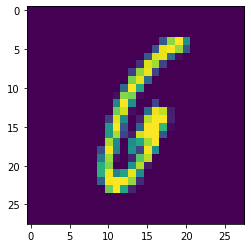

In [ ]:
plt.imshow(x_test[3344])

In [ ]:
#create generator
def create_generator():
  generator = Sequential() #layerları üstüne ekleyeceğimiz yapıyı yarattık.

  generator.add(Dense(units=512, input_dim=100))
  generator.add(ReLU())

  generator.add(Dense(units=512))
  generator.add(ReLU())

  generator.add(Dense(units=1024))
  generator.add(ReLU())

  generator.add(Dense(units=784, activation = "tanh"))

  generator.compile(loss = "binary_crossentropy", optimizer = Adam(lr = 0.0001, beta_1 = 0.5)) #beta kendini güncelleme parametresi

  return generator

In [ ]:
g = create_generator()
g.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               51712     
_________________________________________________________________
re_lu_4 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 784)              

In [ ]:
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Dense(units=1024, input_dim = 784))
  discriminator.add(ReLU())
  discriminator.add(Dropout(0.4))

  discriminator.add(Dense(units=512))
  discriminator.add(ReLU())
  discriminator.add(Dropout(0.4))

  discriminator.add(Dense(units=256))
  discriminator.add(ReLU())

  discriminator.add(Dense(units=1, activation="sigmoid"))

  discriminator.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.001, beta_1=0.5))
  return discriminator

In [ ]:
d = create_discriminator()
d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              803840    
_________________________________________________________________
re_lu_7 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
re_lu_8 (ReLU)               (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [ ]:
#GANs
def create_gan(discriminator, generator):
  discriminator.trainable = False
  gan_input = Input(shape = (100,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs= gan_input, outputs = gan_output)
  gan.compile(loss = "binary_crossentropy", optimizer = "adam")
  return gan

In [ ]:
gans = create_gan(d,g)
gans.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               1643280   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
#Train
epochs = 50
batch_size= 256

In [ ]:
for e in range(epochs):
  for _ in range (batch_size):
    noise = np.random.normal(0,1, [batch_size, 100]) #noise tanımladım
    generated_images = g.predict(noise)#noise u generatora verdim ve bana rastgele bir image generate etti.
    image_batch = x_train[np.random.randint(low = 0, high=x_train.shape[0], size = batch_size)] #256 resim seçenek train içinden
    x = np.concatenate([image_batch, generated_images])

    y_dis = np.zeros(batch_size*2) #discriminator için labellerı yaratıyoruz.
    y_dis[:batch_size] = 1 #bacth size kadar olanlara 1 dedim çünkü onlar gerçek resim. Yani image_batch in labeli 1, generated_images labeli 0
    
    d.trainable = True
    d.train_on_batch(x,y_dis)

    noise = np.random.normal(0,1, [batch_size,100])
    y_gen = np.ones(batch_size)#discriminator ı kandırmak için 1 yaptık

    d.trainable = False

    gans.train_on_batch(noise, y_gen)
  print("Epochs: ", e)

Epochs:  0
Epochs:  1
Epochs:  2
Epochs:  3
Epochs:  4
Epochs:  5
Epochs:  6
Epochs:  7
Epochs:  8
Epochs:  9
Epochs:  10
Epochs:  11
Epochs:  12
Epochs:  13
Epochs:  14
Epochs:  15
Epochs:  16
Epochs:  17
Epochs:  18
Epochs:  19
Epochs:  20
Epochs:  21
Epochs:  22
Epochs:  23
Epochs:  24
Epochs:  25
Epochs:  26
Epochs:  27
Epochs:  28
Epochs:  29
Epochs:  30
Epochs:  31
Epochs:  32
Epochs:  33
Epochs:  34
Epochs:  35
Epochs:  36
Epochs:  37
Epochs:  38
Epochs:  39
Epochs:  40
Epochs:  41
Epochs:  42
Epochs:  43
Epochs:  44
Epochs:  45
Epochs:  46
Epochs:  47
Epochs:  48
Epochs:  49


In [ ]:
g.save_weights('gans_model.h5')

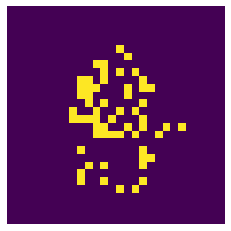

In [ ]:
#visualize
noise = np.random.normal(loc = 0, scale= 1, size= [100,100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100,28,28)
plt.imshow(generated_images[40],interpolation = "nearest")
plt.axis("off")
plt.show()